In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow import keras

import string, os

In [2]:
path = '../input/nyt-comments/'
all_headlines = []
for filename in os.listdir(path):
    if 'Articles' in filename:
        article_df = pd.read_csv(path + filename)
        all_headlines.extend(list(article_df.headline.values))

all_headlines = [x for x in all_headlines if x != "Unknown"]
len(all_headlines)

8603

In [3]:
tokenizer = keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                               lower=True)

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(all_headlines)
inp_sequences[:10]

[[1616, 5242],
 [1616, 5242, 163],
 [1616, 5242, 163, 2514],
 [28, 26],
 [28, 26, 2515],
 [28, 26, 2515, 360],
 [28, 26, 2515, 360, 380],
 [28, 26, 2515, 360, 380, 6],
 [28, 26, 2515, 360, 380, 6, 108],
 [28, 26, 2515, 360, 380, 6, 108, 137]]

In [4]:
all_headlines[0]

'Virtual Coins, Real Resources'

In [5]:
word_index = tokenizer.word_index
word_index['virtual'], word_index['coins'], word_index['real'], word_index['resources']

(1616, 5242, 163, 2514)

In [6]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(keras.preprocessing.sequence.pad_sequences(input_sequences, 
                                                  maxlen=max_sequence_len, padding='pre'))    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = keras.utils.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [11]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = keras.Sequential()    
    # Add Input Embedding Layer
    model.add(keras.layers.Embedding(total_words, 64, input_length=input_len))    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(keras.layers.LSTM(100))
    model.add(keras.layers.Dropout(0.1))    
    # Add Output Layer
    model.add(keras.layers.Dense(total_words, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 27, 64)            752192    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 11753)             1187053   
Total params: 2,005,245
Trainable params: 2,005,245
Non-trainable params: 0
_________________________________________________________________


In [12]:
callbacks = keras.callbacks.EarlyStopping(monitor='loss', patience = 10)
history = model.fit(predictors, label, epochs=100, callbacks = callbacks)

Epoch 1/100
1666/1666 [==============================] - 18s 11ms/step - loss: 7.8886
Epoch 2/100
1666/1666 [==============================] - 19s 11ms/step - loss: 7.4195
Epoch 3/100
1666/1666 [==============================] - 18s 11ms/step - loss: 7.0937
Epoch 4/100
1666/1666 [==============================] - 18s 11ms/step - loss: 6.7297
Epoch 5/100
1666/1666 [==============================] - 19s 11ms/step - loss: 6.3486
Epoch 6/100
1666/1666 [==============================] - 18s 11ms/step - loss: 5.9696
Epoch 7/100
1666/1666 [==============================] - 18s 11ms/step - loss: 5.5941
Epoch 8/100
1666/1666 [==============================] - 19s 11ms/step - loss: 5.2371
Epoch 9/100
1666/1666 [==============================] - 18s 11ms/step - loss: 4.8825
Epoch 10/100
1666/1666 [==============================] - 18s 11ms/step - loss: 4.5488
Epoch 11/100
1666/1666 [==============================] - 18s 11ms/step - loss: 4.2244
Epoch 12/100
1666/1666 [============================

1666/1666 [==============================] - 18s 11ms/step - loss: 0.6748
Epoch 96/100
1666/1666 [==============================] - 19s 12ms/step - loss: 0.6735
Epoch 97/100
1666/1666 [==============================] - 19s 11ms/step - loss: 0.6726
Epoch 98/100
1666/1666 [==============================] - 18s 11ms/step - loss: 0.6686
Epoch 99/100
1666/1666 [==============================] - 19s 12ms/step - loss: 0.6685
Epoch 100/100
1666/1666 [==============================] - 18s 11ms/step - loss: 0.6652


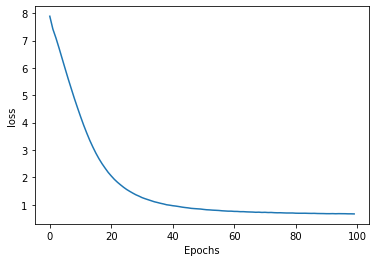

In [14]:
# Plot
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

# plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [17]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = keras.preprocessing.sequence.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [18]:
print (generate_text("united states", 5, model, max_sequence_len))
print (generate_text("president trump", 4, model, max_sequence_len))
print (generate_text("stock market", 4, model, max_sequence_len))
print (generate_text("india and pakistan", 4, model, max_sequence_len))
print (generate_text("new york", 4, model, max_sequence_len))
print (generate_text("science and technology", 5, model, max_sequence_len))

United States Race In Search Of And
President Trump Is In The Building
Stock Market And Conviction In Cut
India And Pakistan Their Disgrace Next Congress
New York Today A Holocaust Survivor’S
Science And Technology For The N F L
